# Analysis of Trending YouTube Videos in the United States

## Hypotheses and Analyses

1. Certain video categories receive more engagement:
    * **Hypothesis**: Some categories (Entertainment, Music, and Education) might attract more average likes per category compared to others because certain types of content naturally draw more engagement from users.
    * **Analysis**: Display the categories with the highest average likes and views. Compare these patterns across the different categories to determine any disparity/trend.
   
   
2. Videos with more views have more likes:
    * **Hypothesis**: Videos that have extremely high view counts may have higher likes-to-views ratio, as more people enjoy popular content and are more likely to like the video.
    * **Analysis**: Plot the likes vs views data and analyze the relationship to see if the ratio of likes to views increases as the view count increases.
    
    
3. Impact of tags on video popularity:
    * **Hypothesis**: Videos that have certain tags associated with trending videos will have more views than those without.
    * **Analysis**: Perform text analysis on the tags associated with trending videos tos ee if certain keywords or tag patterns correlate with higher views or likes.

## Data Wrangling

*In this code, I utilized YouTube's API to fetch data on trending video, stored the data in a CSV file, uploaded it to an AWS S3 bucket, combined the CSV files, and cleaned the data for further analysis.*



1. Fetching data
    * I utilized the YouTube API to request trending videos based on parameters like video IDs, statistics(views, likes, comments), and a maximum number of 200 videos. The request was limited to trending videos from the US region.


2. Storing data
    * The fetched data was written into a CSV file, with columns including video ID, title, channel details, category, and statistics.


3. Uploading data
    * The CSV files were then uploaded to an AWS S3 bucket using boto3, with AWS credentials used for authentication.
    

4. Data processing and cleaning
    * I processed multiple CSV files from a specified timeframe (7 days). While combining the files, if a video was already present in the combined DataFrame, its statistics were updated if the new data showed higher values. A counter was also incremented to track how often the video appeared in the top 200.
    * If any key, such as description or tags, was missing, the value was filled with an empty string to ensure consistency in the dataset.
    


In [3]:
import os
import time
import googleapiclient.discovery
import csv
import boto3
import glob
import pandas as pd


DEVELOPER_KEY = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

def load():

    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)

    print(youtube)

    # Request Parameters
    request_params = {
        "part": "id, statistics, snippet",
        "maxResults": 200,
        "chart": "mostPopular",
        "regionCode": "US"
    }

    # Headers
    id = ['id']
    snippet = ['title', 'channelId', 'channelTitle', 'categoryId', 'publishedAt', 'tags']
    stats = ['viewCount','likeCount', 'commentCount']

    videos = []
    while True:
        # Make request
        response = youtube.videos().list(**request_params).execute()
        
        # Process response
        for idx, att in enumerate(response['items']):
            video = {}
            
            # Extract video id
            video_data = {}
            for key in id:
                try:
                    video_data[key] = att[key]
                except KeyError:
                    video_data[key] = "" 
           
            # Extract snippet
            snippet_data = {}
            for key in snippet:
                try:
                    snippet_data[key] = att['snippet'][key]
                except KeyError:
                    snippet_data[key] = ""
            
            # Extract stats
            stats_data = {}
            for key in stats:
                try:
                    stats_data[key] = att['statistics'][key]
                except KeyError:
                    stats_data[key] = ""
            
            # Combine data
            video[idx] = {**video_data, **snippet_data, **stats_data}

            videos.append(video[idx])
    
        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break
        request_params["pageToken"] = next_page_token

    headers = id + snippet + stats
    filename = f"{time.strftime('%y.%d.%m')}_videos.csv"
    print("Attemping to upload csv to S3...")
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for item in videos:
            row_data = {}
            for key in headers:
                if key in item:
                    row_data[key] = item[key]
            writer.writerow(row_data)

    s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key = AWS_SECRET_ACCESS_KEY)
    with open(filename, "rb") as f:
        s3.upload_fileobj(f, "yt-trendingvideos", filename)
    print("Successfully uploaded csv to S3")

def download_folder(bucket_name, folder_name):
    s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
    print(response)
    try:
        for obj in response.get('Contents', [])[1:]:
            key = obj['Key']
            print(key)
            filename = os.path.basename(key)
            s3.download_file(bucket_name, key, filename)
            print(f"Downloaded {key}")
    except Exception as e:
        print(f"Failed to download folder: {e}")

def check_bucket_access(bucket_name):
    # Create an S3 client
    s3 = boto3.client('s3', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)


    try:
        # List objects in the bucket
        response = s3.list_objects_v2(Bucket=bucket_name)

        # Print object keys
        print("Objects in the bucket:")
        for obj in response.get('Contents', []):
            print(obj['Key'])
        
        print("Access to the bucket is successful.")
        return True
    except Exception as e:
        print(f"Failed to access bucket: {e}")
        return False

def get_bucket_owner(bucket_name):
    # Create an S3 client
    s3 = boto3.client('s3')

    try:
        # Get bucket location
        response = s3.get_bucket_location(Bucket=bucket_name)

        # Get the AWS account ID of the bucket owner
        bucket_owner_id = response['Owner']

        return bucket_owner_id
    except Exception as e:
        print(f"Failed to get bucket owner: {e}")
        return None

def combine_csv():
    csv_files = glob.glob('*.{}'.format('csv'))
    num_of_files = len(csv_files)
    weekly = 7

    if num_of_files > weekly:
        csv_files = csv_files[num_of_files-weekly:num_of_files]

    complete_df = pd.DataFrame()
    for csv in csv_files:
        temp_df = pd.read_csv(csv)
        if 'Counter' not in complete_df.columns:
            complete_df['Counter'] = 1
        if not complete_df.empty:
            for index, row in temp_df.iterrows():
                if row['id'] in complete_df['id'].values:
                    existing_row_index = complete_df.index[complete_df['id'] == row['id']][0]
                    if row['viewCount'] > complete_df.loc[existing_row_index, 'viewCount']:
                        complete_df.loc[existing_row_index, 'viewCount'] = row['viewCount']
                        complete_df.loc[existing_row_index, 'likeCount'] = row['likeCount']
                        complete_df.loc[existing_row_index, 'commentCount'] = row['commentCount']
                    complete_df.loc[existing_row_index, 'Counter'] += 1
                else:
                    complete_df = pd.concat([complete_df, row.to_frame().T], ignore_index=True)
        else:
            complete_df = temp_df.copy()

    complete_df['Counter'].fillna(1, inplace=True)
    complete_df.to_csv('combined.csv', index=False)


def read_csv(file_name='combined.csv'):
    try:
        df = pd.read_csv(file_name)
        print(f"CSV file '{file_name}' successfully loaded.")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist.")
        return None
    
if __name__ == "__main__":
    bucket_name = 'yt-trendingvideos'
    folder_name = 'yt-folder/'
    # get_bucket_owner(bucket_name)
    # download_folder(bucket_name, folder_name)
    # check_bucket_access(bucket_name)
    #load()
    combine_csv()

C:\Users\Patrick\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data Visualization
*In this section I leveraged Tableau to design an interactive dashboard that visually represents and tests key hypotheses about trending videos on YouTube.*

<div>
<img src="img/LikesPerCategory.png" width="1000"/>
</div>

1. Certain video categories receive more engagement:
    * **Hypothesis**: Some categories (Entertainment, Music, and Education) might attract more average likes per category compared to others because certain types of content naturally draw more engagement from users.
    * **Insight**: The data revealed that the *Entertainment* category significantly ourperformed other categories, receiving more than double the average likes compared to the second most popular category, *Film & Animation.* This suggests that the entertainment-related content attracts a wider audience and encourages higher interaction, possibly due to its broad appeal and ease of consumption.

<div>
<img src="img/LikesVsViews.png" width="1000"/>
</div>

2. Videos with more views have more likes:
    * **Hypothesis**: Videos that have extremely high view counts may have higher likes-to-views ratio, as more people enjoy popular content and are more likely to like the video.
    * **Insight**: The analysis demonstrated a strong positive correlation (0.91) between the number of views and likes, indicating that as viewship increases, the likelihood of receiving more likes also rises. The upward trend observed in the graph supports this relationship, confirming that popular videos tend to gain more likes.

In [4]:
df = read_csv()

CSV file 'combined.csv' successfully loaded.


In [5]:
# Ensure tags are in correct format
df['tags'] = df['tags'].fillna("None").apply(lambda x: x.split(','))
df['tags'] = df['tags'].apply(lambda x: [tag.lower() for tag in x])

# Convert columns to numeric values
df['viewCount'] = pd.to_numeric(df['viewCount'], errors='coerce')
df['likeCount'] = pd.to_numeric(df['likeCount'], errors='coerce')
df['commentCount'] = pd.to_numeric(df['commentCount'], errors='coerce')

In [6]:
# Explode tags into individual rows
df_exploded = df.explode('tags')

In [7]:
df_exploded.head()

,id,title,channelId,channelTitle,categoryId,publishedAt,tags,viewCount,likeCount,commentCount,Counter
0,FALlhXl6CmA,Conan O'Brien Needs a Doctor While Eating Spic...,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,24,2024-04-11T15:00:10Z,['first we feast',7305878.0,431194.0,41773.0,7.0
0,FALlhXl6CmA,Conan O'Brien Needs a Doctor While Eating Spic...,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,24,2024-04-11T15:00:10Z,'fwf',7305878.0,431194.0,41773.0,7.0
0,FALlhXl6CmA,Conan O'Brien Needs a Doctor While Eating Spic...,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,24,2024-04-11T15:00:10Z,'firstwefeast',7305878.0,431194.0,41773.0,7.0
0,FALlhXl6CmA,Conan O'Brien Needs a Doctor While Eating Spic...,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,24,2024-04-11T15:00:10Z,'food',7305878.0,431194.0,41773.0,7.0
0,FALlhXl6CmA,Conan O'Brien Needs a Doctor While Eating Spic...,UCPD_bxCRGpmmeQcbe2kpPaA,First We Feast,24,2024-04-11T15:00:10Z,'food porn',7305878.0,431194.0,41773.0,7.0


In [40]:
# Group by tags and calculate average views, likes, and comments
def sort_tags(df):
    df_grouped_tags = df.groupby('tags').agg(
        avg_views=('viewCount', 'mean'),
        avg_likes=('likeCount', 'mean'),
        avg_comments=('commentCount', 'mean'),
        count=('tags', 'size')
    ).reset_index()
    
    tag_popularity = df_grouped_tags.sort_values(by=['count', 'avg_views'], ascending=[False, False])
    return tag_popularity

tag_popularity = sort_tags(df_exploded)

In [41]:
# Get top 10 tags by average views
top_10_by_count = tag_popularity.nlargest(10, 'count')
top_10_by_count.head()

,tags,avg_views,avg_likes,avg_comments,count
4667,none,5.020143e+06,185940.371429,7376.257143,70
1402,'football',1.860999e+06,35543.615385,2696.461538,13
1487,'funny',1.318606e+06,66473.461538,3864.076923,13
3514,'soccer',1.683319e+06,29542.416667,2370.750000,12
2707,'nba',7.849863e+05,15368.833333,2173.666667,12


In [42]:
# Sort the top 10 by views
sorted_top_10 = top_10_by_count.sort_values(by='avg_views', ascending=False)
sorted_top_10.head()

,tags,avg_views,avg_likes,avg_comments,count
4667,none,5.020143e+06,185940.371429,7376.257143,70
2572,'mma',2.970675e+06,45528.444444,5853.888889,9
4161,'wrestling',2.387614e+06,57451.222222,4568.222222,9
1402,'football',1.860999e+06,35543.615385,2696.461538,13
3514,'soccer',1.683319e+06,29542.416667,2370.750000,12


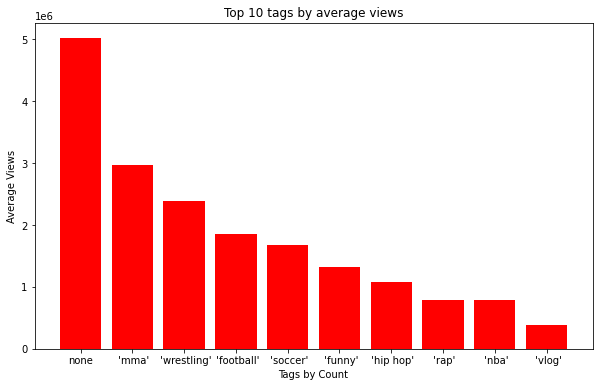

In [44]:
import matplotlib.pyplot as plt

# Plot tags vs. average views
plt.figure(figsize=(10,6))
plt.bar(sorted_top_10['tags'][:10], sorted_top_10['avg_views'][:10], color='red')
plt.xlabel('Tags by Count')
plt.ylabel('Average Views')
plt.title('Top 10 Tags by Average Views')
plt.show()

This data might be skewed since the most popular channel MrBeast does not have any tags in their videos, so in order to get a proper sense of the data, MrBeast data has been removed.

In [45]:
# Remove MrBeast videos from dataframe
df_removed = df_exploded.drop(df_exploded[df_exploded['channelTitle'] == 'MrBeast'].index)

In [46]:
tag_popularity = sort_tags(df_removed)

In [47]:
tag_popularity.head()

,tags,avg_views,avg_likes,avg_comments,count
4667,none,1.511872e+06,56879.544118,3707.647059,68
1402,'football',1.860999e+06,35543.615385,2696.461538,13
1487,'funny',1.318606e+06,66473.461538,3864.076923,13
3514,'soccer',1.683319e+06,29542.416667,2370.750000,12
2707,'nba',7.849863e+05,15368.833333,2173.666667,12


In [49]:
# Get top 10 tags by average views
top_10_by_count = tag_popularity.nlargest(10, 'count')
top_10_by_count.head()

,tags,avg_views,avg_likes,avg_comments,count
4667,none,1.511872e+06,56879.544118,3707.647059,68
1402,'football',1.860999e+06,35543.615385,2696.461538,13
1487,'funny',1.318606e+06,66473.461538,3864.076923,13
3514,'soccer',1.683319e+06,29542.416667,2370.750000,12
2707,'nba',7.849863e+05,15368.833333,2173.666667,12


In [50]:
# Sort the top 10 by views
sorted_top_10 = top_10_by_count.sort_values(by='avg_views', ascending=False)
sorted_top_10.head()

,tags,avg_views,avg_likes,avg_comments,count
2572,'mma',2.970675e+06,45528.444444,5853.888889,9
4161,'wrestling',2.387614e+06,57451.222222,4568.222222,9
1402,'football',1.860999e+06,35543.615385,2696.461538,13
3514,'soccer',1.683319e+06,29542.416667,2370.750000,12
4667,none,1.511872e+06,56879.544118,3707.647059,68


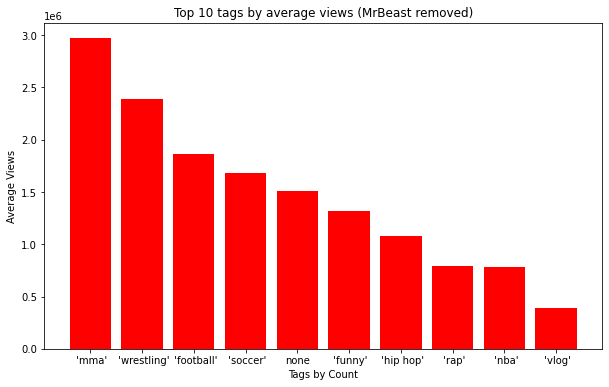

In [52]:
import matplotlib.pyplot as plt

# Plot tags vs. average views
plt.figure(figsize=(10,6))
plt.bar(sorted_top_10['tags'][:10], sorted_top_10['avg_views'][:10], color='red')
plt.xlabel('Tags by Count')
plt.ylabel('Average Views')
plt.title('Top 10 Tags by Average Views (MrBeast removed)')
plt.show()

3. Impact of tags on video popularity:
    * **Hypothesis**: Videos that have certain tags associated with trending videos will have more views than those without.
    * **Insight**: The removal of outlier channels/videos, such as those from MrBeast, reveals that tags play a more meaningful role for the majority of content creators. While the "none" still appeared in the top 10, its significant drop in average views underscores the importance of relevant tagging for most videos. The presence of sports-related tags among the highest-ranked in terms of average views, despite lower overall category performance, suggests that specific tags can help surface niche content with high engagement potential.

## Conclusion

In this project, I analyzed trending YouTube videos in the United States region by leveraging YouTube's API, AWS S3 for data storage, and Tableau for visualization. Through data wrangling and analysis, I explored key hypotheses regarding video popularity, engagement metrics, and the role of tags in trending content.